In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [39]:
raw_data = pd.read_csv("data/FlightPath.csv", header=None)
raw_data

,0,1
0,0.000000,1.000000
1,12.872340,3.622990
2,1.000000,1.000000
3,13.910740,4.694889
4,2.000000,1.000000
...,...,...
63,7.718620,6.381560
64,32.000000,1.000000
65,6.848592,5.578642
66,33.000000,1.000000


In [40]:
csv_index = pd.Index(raw_data[0][::2], dtype='int', name="Scan")
csv_index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
            33],
           dtype='int64', name='Scan')

In [41]:
scan_coords = pd.DataFrame(raw_data[1::2])
scan_coords.columns=['X', 'Y']
scan_coords.index = csv_index
scan_coords

,X,Y
Scan,,
0,12.872340,3.622990
1,13.910740,4.694889
2,14.912220,5.696368
3,15.982300,6.766453
4,16.682690,7.500103
5,17.185110,8.036117
6,17.185110,9.204402
7,17.155300,10.234630
8,17.155300,11.243450


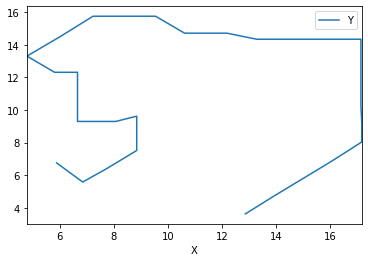

In [42]:
ax1 = scan_coords.plot(x='X', y='Y')

In [43]:
#Read csv and process iteratively

import csv
from collections import defaultdict

dic = defaultdict(list)

with open("data/LIDARPoints.csv", "r") as f:
    reader = csv.reader(f, delimiter=",")
    read_sweep_data = True
    n_sweep_in_scan = 0
    current_sweep = 99999
    current_scan = 0
    for i, line in enumerate(reader):
        if current_sweep < n_sweep_in_scan:             
            #append
            #print(i, line, current_scan)
            dic["Scan"].append(current_scan)
            dic["Angle"].append(float(line[0]))
            dic["Distance"].append(float(line[1]))
            current_sweep += 1
        else:
            current_scan = int(line[0])
            n_sweep_in_scan = int(line[1])
            current_sweep = 0

In [44]:
obstacle_data = pd.DataFrame(dic)
obstacle_data

,Scan,Angle,Distance
0,0,1.096680,8964.0
1,0,1.771484,8967.0
2,0,2.446777,8970.0
3,0,3.121582,8976.0
4,0,3.796875,8982.0
...,...,...,...
18126,33,357.600100,3986.0
18127,33,358.274900,3985.0
18128,33,358.949700,3984.0
18129,33,359.625000,3983.0


In [45]:
obstacle_data_coords = obstacle_data.join(other=scan_coords, on="Scan")

In [46]:
#Filter out outliers, distance < 10cm to the sensor does not make sense

obstacle_data_coords = obstacle_data_coords[obstacle_data_coords["Distance"]> 100]

In [47]:
obstacle_data_coords['X'] = obstacle_data_coords['X'] + ((obstacle_data_coords['Distance'] / 1000) * np.cos(np.radians(obstacle_data_coords['Angle'])))
obstacle_data_coords['Y'] = obstacle_data_coords['Y'] - ((obstacle_data_coords['Distance'] / 1000) * np.sin(np.radians(obstacle_data_coords['Angle'])))

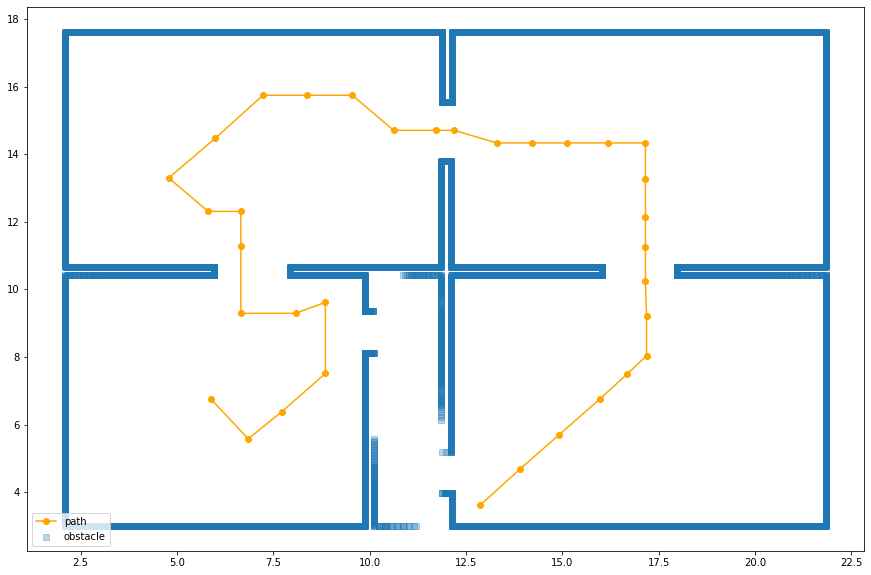

In [48]:
fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(111)

ax1.scatter(obstacle_data_coords['X'][obstacle_data_coords['Scan'] > 0], obstacle_data_coords['Y'][obstacle_data_coords['Scan'] > 0], marker="s", label='obstacle', alpha=0.3)
ax1.plot(scan_coords['X'], scan_coords['Y'], "ok-", label='path', color="orange")

ax1.legend()
plt.show()

In [49]:
grid_coords = obstacle_data_coords[["X", "Y"]].copy()

division_size = 0.1 # 10cm by 10cm subdivisions

X_res = int((grid_coords["X"].max() - grid_coords["X"].min()) / division_size)
Y_res = int((grid_coords["Y"].max() - grid_coords["Y"].min()) / division_size)

X_bin = np.linspace(grid_coords["X"].min(), grid_coords["X"].max(), X_res)
Y_bin = np.linspace(grid_coords["Y"].min(), grid_coords["Y"].max(), Y_res)

x_quantized_coords = np.digitize(grid_coords["X"], bins=X_bin)
y_quantized_coords = np.digitize(grid_coords["Y"], bins=Y_bin)

grid_obstacles_coords = np.c_[x_quantized_coords, y_quantized_coords]
grid_obstacles_coords = grid_obstacles_coords - 1
print(X_res,Y_res)

197 146


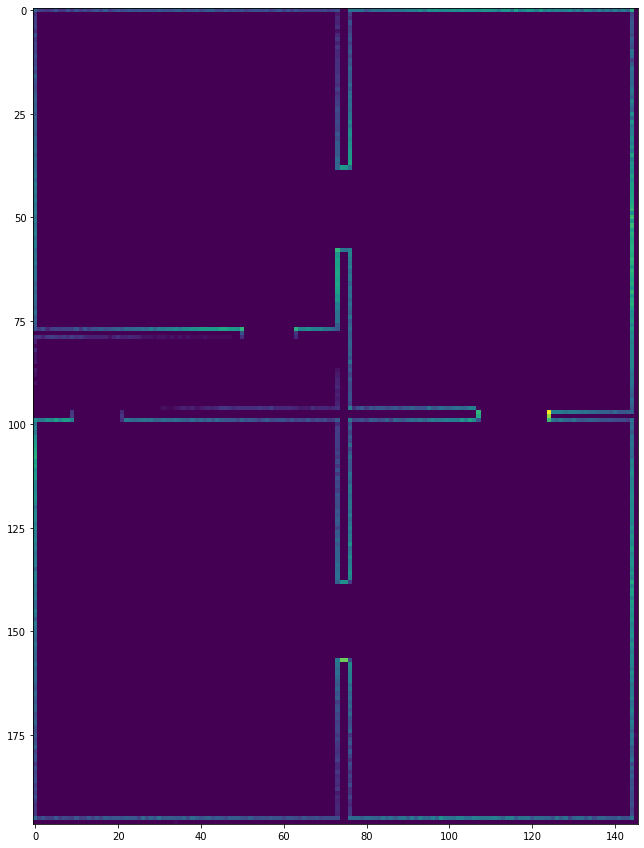

In [50]:
grid = np.zeros((X_res, Y_res), int)
np.add.at(grid, tuple(zip(*grid_obstacles_coords)), 1)

plt.figure(figsize = (20,15))
plt.imshow(grid, interpolation='nearest')

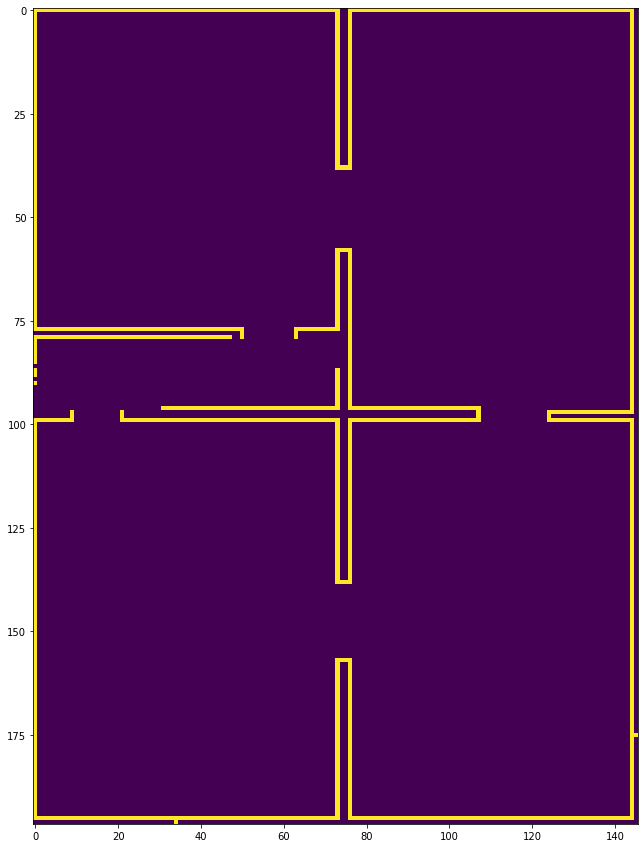

In [51]:
tolerance = 0
bin_map = (grid > tolerance)

plt.figure(figsize = (20,15))
plt.imshow(bin_map)

In [52]:
start_point = scan_coords.iloc[0]
end_point = scan_coords.iloc[-1]

start_quantified = np.array([np.digitize(start_point["X"], bins=X_bin),np.digitize(start_point["Y"], bins=Y_bin)])
end_quantified = np.array([np.digitize(end_point["X"], bins=X_bin),np.digitize(end_point["Y"], bins= Y_bin)])

print(start_quantified, end_quantified)

[108   7] [38 38]


In [53]:
# A*

import math

def distance(position, reference_point):
    #compute heuristic cost
    return math.sqrt(math.pow(position[0] - reference_point[0], 2) + math.pow(position[1] - reference_point[1], 2))


class Node:
    def __init__(self, coords, parent=None):
        self.coords = coords
        self.parent = parent
        if parent:
            self.h = distance(coords, end_quantified)
            self.g = distance(coords, parent.coords) + parent.g
            self.f = self.h + self.g  
        else:
            self.h = distance(coords, end_quantified)
            self.g = 0
            self.f = self.h
            print("No parent")
            
    def __hash__(self):
        return hash(tuple(self.coords))
    
    def __str__(self):
        return "Node " + str(tuple(self.coords)) + ", parent: " + str(self.parent.coords) + ", f: " + str(self.f)
    
    #def __repr__(self):
    #    return self.__str__()
    
class PathFinding:
    def __init__(self):
        self.open_hashmap = dict()
        start_node = Node(start_quantified)
        self.open_hashmap[tuple(start_node.coords)] = start_node
        
        self.closed_set = set()
        self.current_node = None
        self.drone_radius = 2
    
    
    def is_colliding(self, coords):
        #check if drone is in bounds
        if coords[0] - self.drone_radius >= 0 and coords[0] + self.drone_radius < bin_map.shape[0]:
            if coords[1] - self.drone_radius >= 0 and coords[1] + self.drone_radius < bin_map.shape[1]:
                # check if drone is colliding an obstacle
                collision_map = bin_map[coords[0] - self.drone_radius:coords[0] + self.drone_radius+ 1,
                    coords[1] - self.drone_radius:coords[1] + self.drone_radius+ 1]
                if not np.any(collision_map):
                    return False

        return True
    
    def is_shorter_path_to_node(self, node):
        if node in self.open_hashmap:
            if self.open_hashmap[tuple(node.coords)].f > node.f:
                print("Replace ", self.open_hashmap[tuple(node.coords)], " with ", node)
                self.open_hashmap[tuple(node.coords)] = node
                return True
            
        return False

    def check_neighbors(self, node):
        # compute all f-cost from all 8-neighbors


        neighbors_offset = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
        for neigh_offset in neighbors_offset:
            neigh_coords = node.coords + neigh_offset
            
            if(not self.is_colliding(neigh_coords)):
                neigh_node = Node(neigh_coords, self.current_node)
                
                if neigh_node not in self.closed_set:
                    if neigh_node not in self.open_hashmap or self.is_shorter_path_to_node(neigh_node):
                        
                        if neigh_node not in self.open_hashmap:
                            self.open_hashmap[tuple(neigh_coords)] = neigh_node
                            #print("Add: ", neigh_node)
                else:
                    print("Closed skip")
            
            

    def astar(self):
        
        while self.open_hashmap:
            self.current_node = min(self.open_hashmap.values(),key=lambda k: k.f)
            
            del self.open_hashmap[tuple(self.current_node.coords)]
            self.closed_set.add(self.current_node)

            if np.array_equal(self.current_node.coords, end_quantified):
                print("Found path")
                break
            
            self.check_neighbors(self.current_node)
            
            
        
        
        backtrack = []
        node = self.current_node
        
        while node:
            backtrack.append(node.coords)
            node = node.parent
 
        path = np.stack(backtrack)
        print(path)
        #print(self.closed_set)
        return path
    
    
    
pf = PathFinding()
path = pf.astar()

No parent
Found path
[[ 38  38]
 [ 39  39]
 [ 40  39]
 [ 41  39]
 [ 42  40]
 [ 43  40]
 [ 44  41]
 [ 45  41]
 [ 46  42]
 [ 47  42]
 [ 48  43]
 [ 49  43]
 [ 50  43]
 [ 51  44]
 [ 52  44]
 [ 53  45]
 [ 54  45]
 [ 55  46]
 [ 56  46]
 [ 57  47]
 [ 58  47]
 [ 59  48]
 [ 60  48]
 [ 61  48]
 [ 62  49]
 [ 63  49]
 [ 64  50]
 [ 65  50]
 [ 66  51]
 [ 67  51]
 [ 68  52]
 [ 69  52]
 [ 70  53]
 [ 71  53]
 [ 72  53]
 [ 73  53]
 [ 74  53]
 [ 75  53]
 [ 76  53]
 [ 77  53]
 [ 78  53]
 [ 79  53]
 [ 80  53]
 [ 81  53]
 [ 82  52]
 [ 82  51]
 [ 82  50]
 [ 82  49]
 [ 82  48]
 [ 82  47]
 [ 82  46]
 [ 82  45]
 [ 82  44]
 [ 82  43]
 [ 82  42]
 [ 82  41]
 [ 82  40]
 [ 82  39]
 [ 82  38]
 [ 82  37]
 [ 82  36]
 [ 82  35]
 [ 82  34]
 [ 82  33]
 [ 82  32]
 [ 82  31]
 [ 82  30]
 [ 82  29]
 [ 82  28]
 [ 82  27]
 [ 82  26]
 [ 82  25]
 [ 82  24]
 [ 82  23]
 [ 82  22]
 [ 82  21]
 [ 82  20]
 [ 82  19]
 [ 82  18]
 [ 83  18]
 [ 84  17]
 [ 85  17]
 [ 86  16]
 [ 87  16]
 [ 88  15]
 [ 89  15]
 [ 90  14]
 [ 91  14]
 [ 92  13]


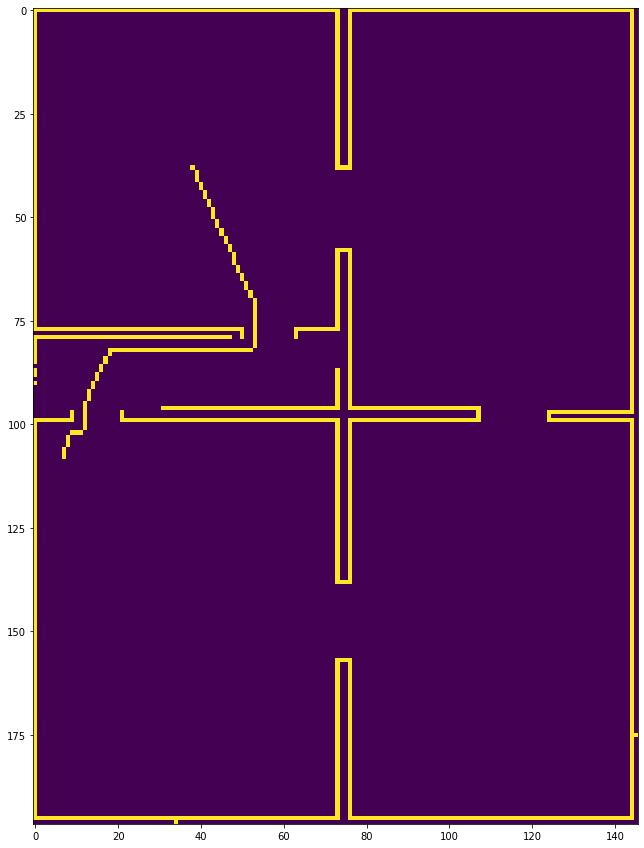

In [54]:
np.add.at(bin_map, tuple(zip(*path)), True)

plt.figure(figsize = (20,15))
plt.imshow(bin_map, interpolation='nearest')